# Rain Forecast Predictive Modeling Using Machine Learning

## Imports
The following code installs and imports the necesssary libraries.

In [ ]:
import pandas as pd
import torch
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    Dataset
)
import torch.nn as nn
import torch.optim as optim
from torch.optim import (Optimizer, Adam)
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np

## Functions
The following section contains functions that will be reused throughout the document

In [ ]:
# Creates a TensorDataset from a Dataframe
def make_dataset(df: pd.DataFrame) -> Dataset:
    features = torch.tensor(df.drop('rain', axis=1).values, dtype=torch.float32)
    target = torch.tensor(df['rain'].values, dtype=torch.int64)
    return TensorDataset(features, target)

# Creates a DataLoader from the TensorDataset
def make_dataloader(dataset: Dataset, batch_size:int, shuffle:bool) -> DataLoader:
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Training loop for multiclass classification
def train_multiclass(model: nn.Module, optimizer: Optimizer, dataloader: DataLoader, epochs: int):
    history = []
    accuracy = Accuracy(task='multiclass', num_classes=3)

    class_weights = torch.tensor([1.0, 0.90, 2.1], dtype=torch.float32)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    for epoch in range(epochs):
        total_loss = 0.0
        accuracy.reset()  # Reset accuracy metric at the start of each epoch

        for (x, target) in dataloader:
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, target)
            loss.backward()
            optimizer.step()

            # Update loss and accuracy metrics
            total_loss += loss.item()
            accuracy.update(torch.argmax(torch.softmax(pred, dim=1), dim=1), target)

        # Compute epoch metrics
        epoch_loss = total_loss / len(dataloader)
        epoch_acc = accuracy.compute().item()
        metrics = {
            'epoch': epoch,
            'loss': epoch_loss,
            'acc': epoch_acc
        }

        if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
            print("{epoch}: loss={loss:.4f}, acc={acc:.2f}".format(**metrics))
        history.append(metrics)

    return pd.DataFrame(history)

# Data normalizer
def normalize(df):
  scaler = MinMaxScaler()
  scaler.fit(df.drop('rain', axis=1))
  scaled_features = scaler.transform(df.drop('rain', axis=1))
  scaled_df = pd.DataFrame(scaled_features, columns=df.drop('rain', axis=1).columns)
  scaled_df['rain'] = df['rain']
  return scaled_df

# Encodes the rain values into three distinct categories
def categorize_rain(rain_amount):
  if rain_amount == 0:
    return 0  # No rain if 0mm per hour
  elif rain_amount > 0 and rain_amount <= 2.5:
    return 1  # Light rain 0mm - 2.5mm per hour
  else:
    return 2  # Moderate/Heavy rain if > 2.5mm per hour

# Combines every two rows into a single maximized row
def max_df(df):
  num_groups = len(df) // 2
  max_df = df.groupby(df.index // 2).max()
  max_df = max_df[:num_groups]
  return max_df

## Classifiers
Following code defines the models

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MLPClassifier, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.output(x)
        return x

## Data Load
The following will load and clean the data

In [ ]:
# Load data from file
df = pd.read_csv('training_data.csv').drop('time', axis=1)

# Reduce and maximize dataset
df = max_df(df)

# Encode rain values
df['rain'] = df['rain'].apply(categorize_rain)

# Separate rows with rain and no rain
rain_df = df[df['rain'].isin([1, 2])]
no_rain_df = df[df['rain'] == 0]

# Get the number of rain entries
num_rain_rows = len(rain_df)

# Sample no_rain rows to match the number of rain rows
no_rain_df_sampled = no_rain_df.sample(n=num_rain_rows, random_state=42)  # random_state for reproducibility

# Merge dataframes
balanced_df = pd.concat([rain_df, no_rain_df_sampled])

# Reset index
df = balanced_df.reset_index(drop=True)

# Normalize the data
df = normalize(df)
df

,temperature,humidity,dew_point,surface_pressure,cloud_cover,wind_speed,rain
0,0.325773,0.866667,0.554639,0.638669,1.00,0.346908,1
1,0.294845,0.986667,0.558763,0.632330,1.00,0.452489,1
2,0.309278,0.893333,0.560825,0.618067,1.00,0.386124,1
3,0.313402,0.920000,0.571134,0.597464,1.00,0.407240,1
4,0.321649,0.920000,0.577320,0.564184,1.00,0.417798,1
...,...,...,...,...,...,...,...
4575,0.538144,0.786667,0.758763,0.714739,1.00,0.191554,0
4576,0.463918,0.693333,0.645361,0.705230,0.03,0.158371,0
4577,0.540206,0.800000,0.756701,0.570523,0.97,0.291101,0
4578,0.441237,0.840000,0.670103,0.651347,0.00,0.067873,0


In [ ]:
df['rain'].value_counts()

,count
rain,
0,2290
1,1856
2,434


In [ ]:
train_dataset = make_dataset(df)
train_dataloader = make_dataloader(train_dataset, shuffle=True, batch_size=100)

first_batch = next(iter(train_dataloader))

## Training
The following trains the two models

In [ ]:
# Get the input dimension from the first batch
input_dim = first_batch[0].shape[1]

# Define the output dimension (number of classes)
output_dim = 3

# Instantiate the model
model = LinearClassifier(input_dim, output_dim)
optimizer = Adam(model.parameters())
history_linear = train_multiclass(model, optimizer, train_dataloader, 100)

0: loss=1.0047, acc=0.67
10: loss=0.8857, acc=0.73
20: loss=0.8233, acc=0.73
30: loss=0.7872, acc=0.74
40: loss=0.7632, acc=0.74
50: loss=0.7480, acc=0.74
60: loss=0.7365, acc=0.74
70: loss=0.7262, acc=0.74
80: loss=0.7200, acc=0.75
90: loss=0.7144, acc=0.75
99: loss=0.7096, acc=0.75


In [ ]:
# Instantiate the model
mlp = MLPClassifier(input_dim, output_dim, 200)
optimizer_mlp = Adam(mlp.parameters(), lr=0.01)
dataloader = make_dataloader(train_dataset, shuffle=True, batch_size=100)

history_mlp = train_multiclass(mlp, optimizer_mlp, dataloader, 100)

0: loss=0.7886, acc=0.69
10: loss=0.6114, acc=0.75
20: loss=0.6040, acc=0.75
30: loss=0.5932, acc=0.75
40: loss=0.5870, acc=0.76
50: loss=0.5833, acc=0.76
60: loss=0.5854, acc=0.76
70: loss=0.5856, acc=0.75
80: loss=0.5766, acc=0.76
90: loss=0.5795, acc=0.75
99: loss=0.5772, acc=0.76


## Training Results
The following analyzes the training results from the two models

Text(0, 0.5, 'Accuracy')

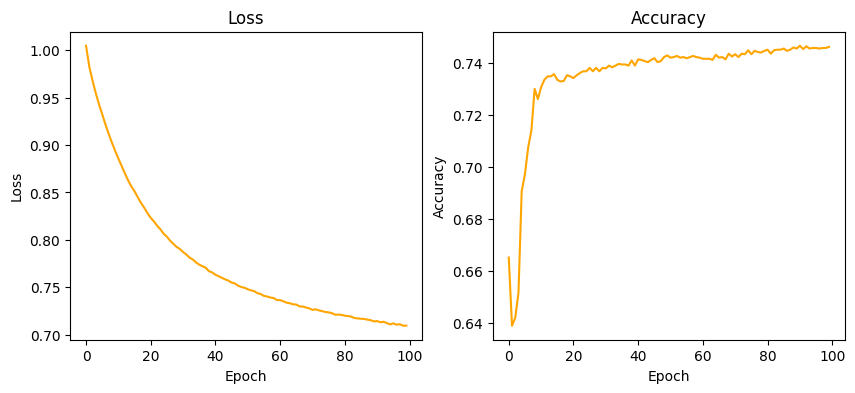

In [ ]:
# Plotting loss function and accuracy of the Linear Classifier
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

axes[0].plot(history_linear['epoch'], history_linear['loss'], color='orange')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(history_linear['epoch'], history_linear['acc'], color='orange')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

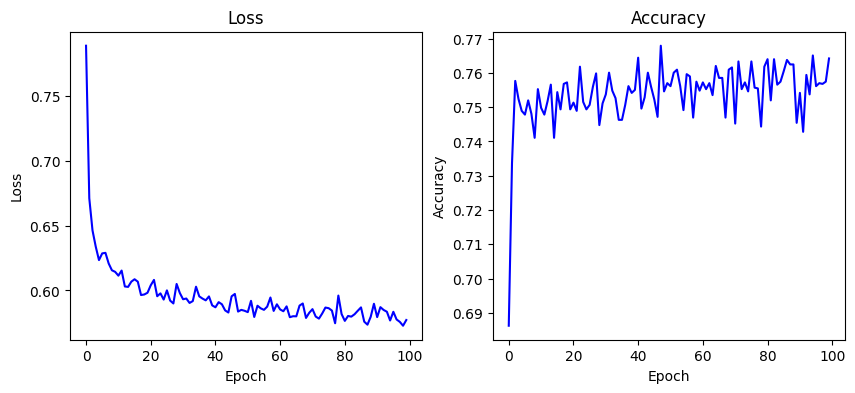

In [ ]:
# Plotting loss function and accuracy of the MLP Classifier

fig, axes = plt.subplots(ncols=2, figsize=(10,4))

axes[0].plot(history_mlp['epoch'], history_mlp['loss'], color='blue')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(history_mlp['epoch'], history_mlp['acc'], color='blue')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

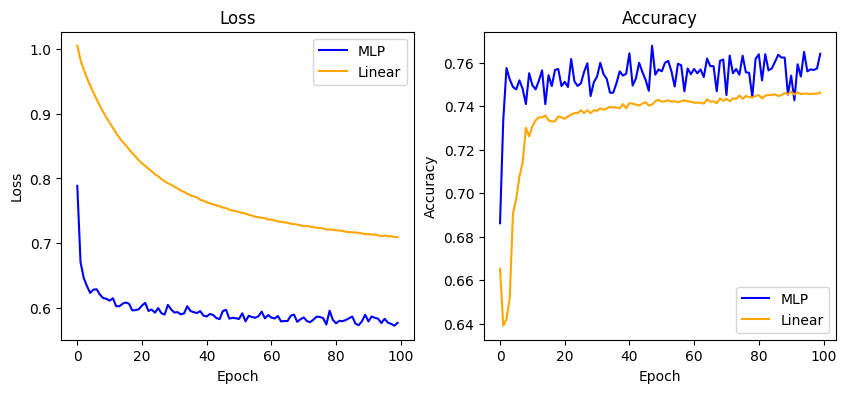

In [ ]:
# Comaparing the loss and accuracies of both of the classifiers
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

axes[0].plot(history_mlp['epoch'], history_mlp['loss'], label='MLP', color='blue')
axes[0].plot(history_linear['epoch'], history_linear['loss'], label='Linear', color='orange')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_mlp['epoch'], history_mlp['acc'], label='MLP', color='blue')
axes[1].plot(history_linear['epoch'], history_linear['acc'], label='Linear', color='orange')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()


In [ ]:
# Compare predictions to actual
X = torch.tensor(df.drop('rain', axis=1).values, dtype=torch.float32)
y_true = torch.tensor(df['rain'].values, dtype=torch.int64)

with torch.no_grad():
    # Apply the model to get logits
    logits = mlp(X)

    # Convert logits to probabilities using softmax
    y_pred_probs = torch.softmax(logits, dim=1)

    # Get the predicted class (index of the maximum probability)
    y_pred = y_pred_probs.argmax(dim=1)

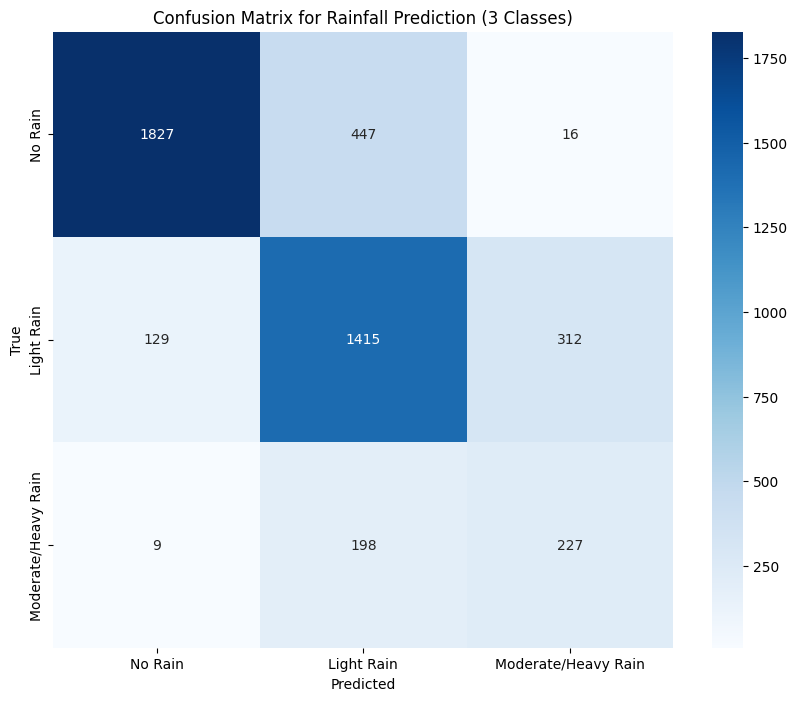

In [ ]:
# creating confusion matrix detailing how many times model correctly and incorrectly predicted rain or no rain
# top left are correctly predicted no rain, top right are incorrectly predicted rain
# bottom left are incorrectly predicted rain, bottom right are correctly predicted rain

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))  # Adjust size if needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Rain', 'Light Rain', 'Moderate/Heavy Rain'],  # Update x-axis labels
            yticklabels=['No Rain', 'Light Rain', 'Moderate/Heavy Rain'])  # Update y-axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Rainfall Prediction (3 Classes)')
plt.show()

## Real-World Predictions
Using the models to predict rain forecast and compare to actual forecast.

In [ ]:
# Creating testing data

import requests
import json
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Define the API endpoint and parameters for Vancouver, BC
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 49.2497,
    "longitude": -123.1193,
    "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "dew_point_2m", "wind_speed_80m", "cloud_cover", "surface_pressure"],
    "forecast_days": 16
}


responses = openmeteo.weather_api(url, params=params)

response = responses[0]


hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_80m = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_dew_point = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {
    "temperature_2m": hourly_temperature_2m,
    "relative_humidity_2m": hourly_relative_humidity_2m,
    "dew_point_2m": hourly_dew_point,
    "surface_pressure": hourly_surface_pressure,
    "cloud_cover": hourly_cloud_cover,
    "wind_speed_80m": hourly_wind_speed_80m,
    "rain":hourly_rain
}

hourly_dataframe = pd.DataFrame(data=hourly_data)

# Take the maximum values from every 2 hours
num_groups = len(hourly_dataframe) // 2
max_df = hourly_dataframe.groupby(hourly_dataframe.index // 2).max()
max_df = max_df[:num_groups]
max_df = max_df.reset_index(drop=True)
hourly_dataframe = max_df



hourly_dataframe = normalize(hourly_dataframe)
hourly_dataframe['rain'] = hourly_dataframe['rain'].apply(categorize_rain)
hourly_dataframe.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_80m,rain
0,0.515582,0.805556,0.655517,0.366159,1.0,0.428863,1
1,0.544225,0.833333,0.691930,0.318350,1.0,0.358794,1
2,0.532768,0.944445,0.715894,0.306160,1.0,0.492778,1
3,0.492667,0.916667,0.679640,0.294065,1.0,0.500677,1
4,0.492667,0.888889,0.637715,0.278589,1.0,0.453791,1


In [ ]:
target_summary = []
prediction_summary = []

test_dataset = make_dataset(hourly_dataframe)
test_dataloader = make_dataloader(test_dataset, batch_size=100, shuffle=False)

def evaluate(model, dataloader):
    model.eval()  # Set model mode to evaluation
    accuracy = Accuracy(task='multiclass', num_classes=3)  # Adjust num_classes if needed
    total_loss = 0

    with torch.no_grad():  # We don't want to track gradients during evaluation
        for x, target in dataloader:
            pred = model(x)
            loss = nn.CrossEntropyLoss()(pred, target)  # Use CrossEntropyLoss for multi-class
            total_loss += loss.item()

            # Get predictions and compute accuracy
            pred_classes = torch.argmax(torch.softmax(pred, dim=1), dim=1)
            accuracy.update(pred_classes, target)
            for pred, targ in zip(pred_classes, target):
                # Print predictions and actual values
                print(f"Predicted: {pred.item()}, Actual: {targ.item()}")
                target_summary.append(targ.item())
                prediction_summary.append(pred.item())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = accuracy.compute().item()  # Get final accuracy

    return avg_loss, acc
# Example usage
# Run the evaluation on the test set
test_loss, test_acc = evaluate(mlp, test_dataloader)
print(f"Testing Data Evaluation: Loss = {test_loss:.4f}, Accuracy = {test_acc:.2f}")



Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Ac

In [ ]:
# Convert mean rain score to text
def mean_to_text(index):
    if index == 0:
        return "No Rain"
    # If it is mix of light and heavy, classify as heavy
    elif index > 0 and index <= 1:
        return "Light Rain"
    elif index > 1:
        return "Moderate/Heavy Rain"
    else:
        return "Unknown"

# Convert single rain score to text
def index_to_text(index):
    if index == 0:
        return "No Rain"
    elif index == 1:
        return "Light Rain"
    elif index == 2:
        return "Moderate/Heavy Rain"
    else:
        return "Unknown"

# Create summary and comparison to actual forecast
def generate_weather_summary(predictions, targets, days=16):
    # Predictions cover 2-hour intervals (12 per day)
    intervals_per_day = 12
    predictions = np.array(predictions)
    targets = np.array(targets)

    summary = []

    for day in range(days):
        day_start = day * intervals_per_day
        day_end = day_start + intervals_per_day

        # Extract predictions and targets for the current day
        daily_predictions = predictions[day_start:day_end]
        daily_targets = targets[day_start:day_end]

        # Compute statistics
        mean_pred = mean_to_text(np.mean(daily_predictions))
        min_pred = index_to_text(np.min(daily_predictions))
        max_pred = index_to_text(np.max(daily_predictions))
        actual_mean = mean_to_text(np.mean(daily_targets))

        # Append day summary
        summary.append({
            "Day": day + 1,
            "Mean Prediction": mean_pred,
            "Min Prediction": min_pred,
            "Max Prediction": max_pred,
            "Actual Mean": actual_mean
        })

    return pd.DataFrame.from_dict(summary)

generate_weather_summary(prediction_summary, target_summary)

,Day,Mean Prediction,Min Prediction,Max Prediction,Actual Mean
0,1,Light Rain,No Rain,Moderate/Heavy Rain,Light Rain
1,2,Light Rain,No Rain,Light Rain,Light Rain
2,3,Light Rain,No Rain,Light Rain,Light Rain
3,4,No Rain,No Rain,No Rain,No Rain
4,5,Light Rain,No Rain,Light Rain,Moderate/Heavy Rain
5,6,No Rain,No Rain,No Rain,Light Rain
6,7,No Rain,No Rain,No Rain,Light Rain
7,8,No Rain,No Rain,No Rain,Light Rain
8,9,Light Rain,No Rain,Light Rain,Light Rain
9,10,Light Rain,No Rain,Light Rain,Light Rain


In [ ]:
torch.save(mlp.state_dict(), "model.pth")